# Predicting ENSO
### Source: Libby Barnes
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/ml_tutorial_csu/tree/main/code/)
### Edited by: Kirsten Mayer & Will Chapman
Here we are training a classifier to predict whether an El Nino or La Nina event is occuring. The input is a map of global SST, and the output is a classification of either 1=El Nino or 0=La Nino

### Load Libraries

In [1]:
!pip install wget
!pip install cartopy
import wget

from google.colab import drive
drive.mount('/content/drive')

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl

import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential

# set seeds
random_seed = 36
np.random.seed(random_seed)
tf.random.set_seed(int(random_seed))

#nice figures
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['font.size'] = 12

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=ad234547af67c00695b72d1579c2a0cf231b9b06060399cc8ae1f9c75e2355c1
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 22.0 MB/s eta 0:00:00
Mounted at /content/drive


## Preprocessing
Load in the data from the netcdf. This is ERSSTv5 which has been deseasoned, linearly detrended, and has a 5 month lookback running mean applied. From this, we can calculate the Nino3.4 index.

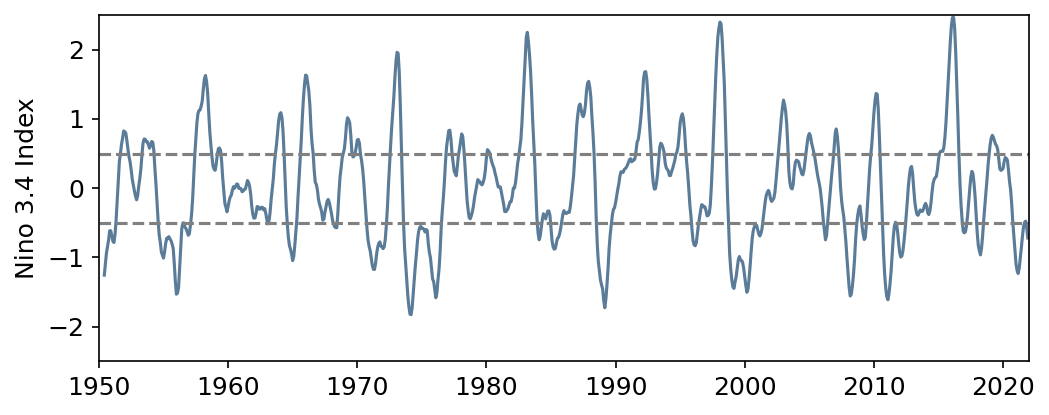

In [2]:
# ---- OPEN dataset ----
## if you need to download the file uncomment:
# url = 'https://eabarnes-data.atmos.colostate.edu/tutorials/ERSSTv5_deseasoneddetrended_5monthrunningmean_1950-2021.nc'
# wget.download(url)

## if file is already downloaded uncomment:
path = '' # For example: '/content/drive/My Drive/OtherPresentations/Lectures/OA2024_CUBoulder/'
filename = 'ERSSTv5_deseasoneddetrended_5monthrunningmean_1950-2021.nc'

sstds = xr.open_dataset(path+filename,decode_times=False)
sst = sstds.sst
sst = sst.where((sst.lat <= 30) & (sst.lat >= -30), drop=True) # select the tropics
lat = np.asarray(sst.lat) #latitude array
lon = np.asarray(sst.lon) #longitude array
time = sstds.time # time array

# ---- CALCULATE nino3.4 index (output) ----
# Define the nino3.4 box (5S-5N, 190E-240E)
LAT_S, LAT_N = -5, 5
LON_W, LON_E = 190, 240
# select nino3.4 box and convert xarray into a numpy array
sstnino = np.asarray(sst.sel(lat=slice(LAT_S,LAT_N),lon=slice(LON_W,LON_E)))
# take mean over nino3.4 box (this is our index)
nino34 = np.nanmean(sstnino,axis=(1,2))

# ---- PLOT the nino3.4 index ----
plt.figure(figsize=(8,3))
timevec = np.arange(1950+(5/12),2022,1/12) #time vector for plotting the x axis
plt.plot(timevec,nino34,color='xkcd:slate blue')
plt.hlines(0.5,1950,2022,linestyle='dashed',color='grey')
plt.hlines(-0.5,1950,2022,linestyle='dashed',color='grey')
plt.xlim(1950,2022)
plt.ylim(-2.5,2.5)
plt.ylabel("Nino 3.4 Index")
plt.show()

## Data preparation
First, we need to include only samples where nino event is occuring (i.e. nino3.4>0.5 or nino3.4<-0.5). Then, we will divide the sst input and nino3.4 output into training, validation and testing chunks.

Some questions to ponder:


1. What happens if we define an El Nino or La Nina as +/- 1 or +/- 2 or +/- 0.25?
2. What happens if we randomly select training, validation and testing?
3. Can you get similar performance if there was a lead time between the input and output?



In [3]:
# ---- FIND El Nino and La Nina events ----
nino_magnitude = 0.5

nino_occur = nino34[(nino34>nino_magnitude) | (nino34<(-1*nino_magnitude))] # only samples where nino event occurs
nino_occur[nino_occur>nino_magnitude] = 1 # make into categorical format, 1 for El Nino and 0 for La Nina
nino_occur[nino_occur<nino_magnitude] = 0

nino_occur = tf.keras.utils.to_categorical(nino_occur) # format accepted by NN
sizefull = nino_occur.shape[0]

# ---- PREPARE input (SST) and output (El Nino/La Nina) ----
train_val_test = [0.7,0.85,1] # set train/val/test fraction

sst = np.asarray(sst) # convert xarray to numpy
sizesst = sst.shape
sstnino_occur = sst[(nino34>0.5) | (nino34<-0.5),:,:] # grab sst samples where nino occurs
sstnino_occur = np.reshape(sstnino_occur,(sizefull,sizesst[1]*sizesst[2])) # reshape latxlon to vectors

trainind = range(int(train_val_test[0]*sizefull))
valind = range(int(train_val_test[0]*sizefull),int(train_val_test[1]*sizefull))
testind = range(int(train_val_test[1]*sizefull),int(train_val_test[2]*sizefull))

# ---- SPLIT into training, validation, and testing ----
# input
sst_train = sstnino_occur[trainind,:]
sst_val = sstnino_occur[valind,:]
sst_test = sstnino_occur[testind,:]

# output
nino_train  = nino_occur[trainind]
nino_val = nino_occur[valind]
nino_test = nino_occur[testind]

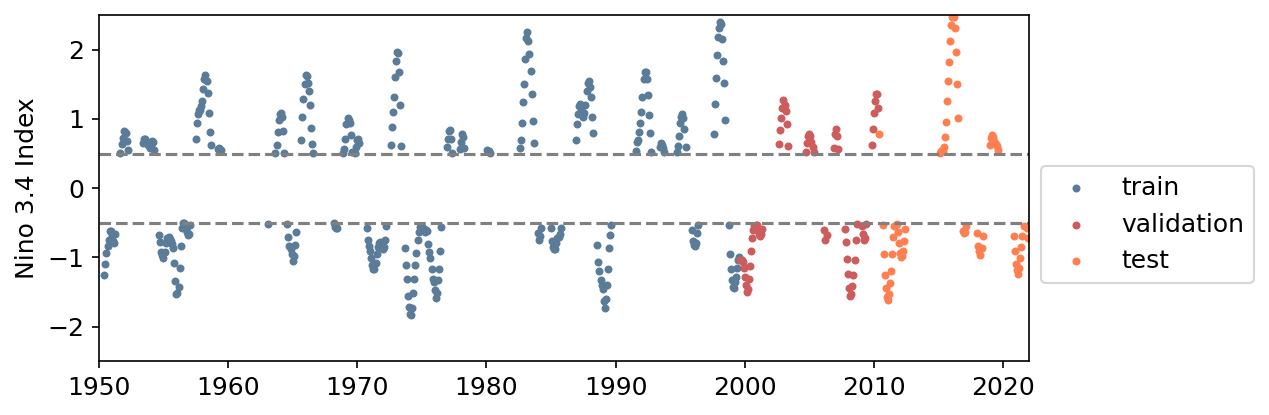

In [9]:
# ---- PLOT output colored by dataset (training, validation or testing) ----
plt.figure(figsize=(8,3))
plt.scatter(timevec[(nino34>0.5) | (nino34<-0.5)][trainind],nino34[(nino34>0.5) | (nino34<-0.5)][trainind],color='xkcd:slate blue', s=8, label = "train")
plt.scatter(timevec[(nino34>0.5) | (nino34<-0.5)][valind],nino34[(nino34>0.5) | (nino34<-0.5)][valind],color='indianred', s=8, label = "validation")
plt.scatter(timevec[(nino34>0.5) | (nino34<-0.5)][testind],nino34[(nino34>0.5) | (nino34<-0.5)][testind],color='coral', s=8, label = "test")
plt.hlines(0.5,1950,2022,linestyle='dashed',color='grey')
plt.hlines(-0.5,1950,2022,linestyle='dashed',color='grey')
plt.xlim(1950,2022)
plt.ylim(-2.5,2.5)
plt.ylabel("Nino 3.4 Index")
plt.legend(bbox_to_anchor=(1, 0.4, .1, 0.2))
plt.show()

In [10]:
# ---- STANDARDIZE our input ----
sst_std = np.std(sst_train,axis=0) # standardized by the TRAINING STD (mean has already been removed)

sst_train = np.divide(sst_train,sst_std)
sst_val = np.divide(sst_val,sst_std)
sst_test = np.divide(sst_test,sst_std)

sst_train[np.isnan(sst_train)] = 0 # set all nans to zeros (they are learned to be ignored)
sst_val[np.isnan(sst_val)] = 0
sst_test[np.isnan(sst_test)] = 0

## Neural Network

### Set some neural network parameters
Here we define parts of the neural network architecture and training parameters

What would you need to change in the network architecture/set up for this to become a regression problem?

In [27]:
# parameters to play with:

HIDDENS = [10, 5] # hidden layers e.g. [10,20] means two hidden layers, 10 nodes connected to 20 nodes
RIDGE_PEN = 0.25 # L2/ridge penalty applied to input
LR = 0.1 # learning rate
N_EPOCHS = 20 # number training epochs
BATCH_SIZE = 32
ACT_FUNC = 'relu'
LOSS_FUNC = 'categorical_crossentropy'

Epoch 1/20
11/11 - 1s - loss: 27.3038 - categorical_accuracy: 0.8796 - val_loss: 15.0910 - val_categorical_accuracy: 1.0000 - 1s/epoch - 119ms/step
Epoch 2/20
11/11 - 0s - loss: 14.9061 - categorical_accuracy: 0.6574 - val_loss: 8.3030 - val_categorical_accuracy: 0.9571 - 108ms/epoch - 10ms/step
Epoch 3/20
11/11 - 0s - loss: 5.6069 - categorical_accuracy: 0.8735 - val_loss: 10.4334 - val_categorical_accuracy: 0.9429 - 88ms/epoch - 8ms/step
Epoch 4/20
11/11 - 0s - loss: 16.3738 - categorical_accuracy: 0.7901 - val_loss: 10.4636 - val_categorical_accuracy: 0.4143 - 112ms/epoch - 10ms/step
Epoch 5/20
11/11 - 0s - loss: 11.2622 - categorical_accuracy: 0.5000 - val_loss: 10.2800 - val_categorical_accuracy: 1.0000 - 112ms/epoch - 10ms/step
Epoch 6/20
11/11 - 0s - loss: 6.0122 - categorical_accuracy: 0.6944 - val_loss: 3.6947 - val_categorical_accuracy: 0.5857 - 103ms/epoch - 9ms/step
Epoch 7/20
11/11 - 0s - loss: 2.7228 - categorical_accuracy: 0.4815 - val_loss: 1.9519 - val_categorical_accu

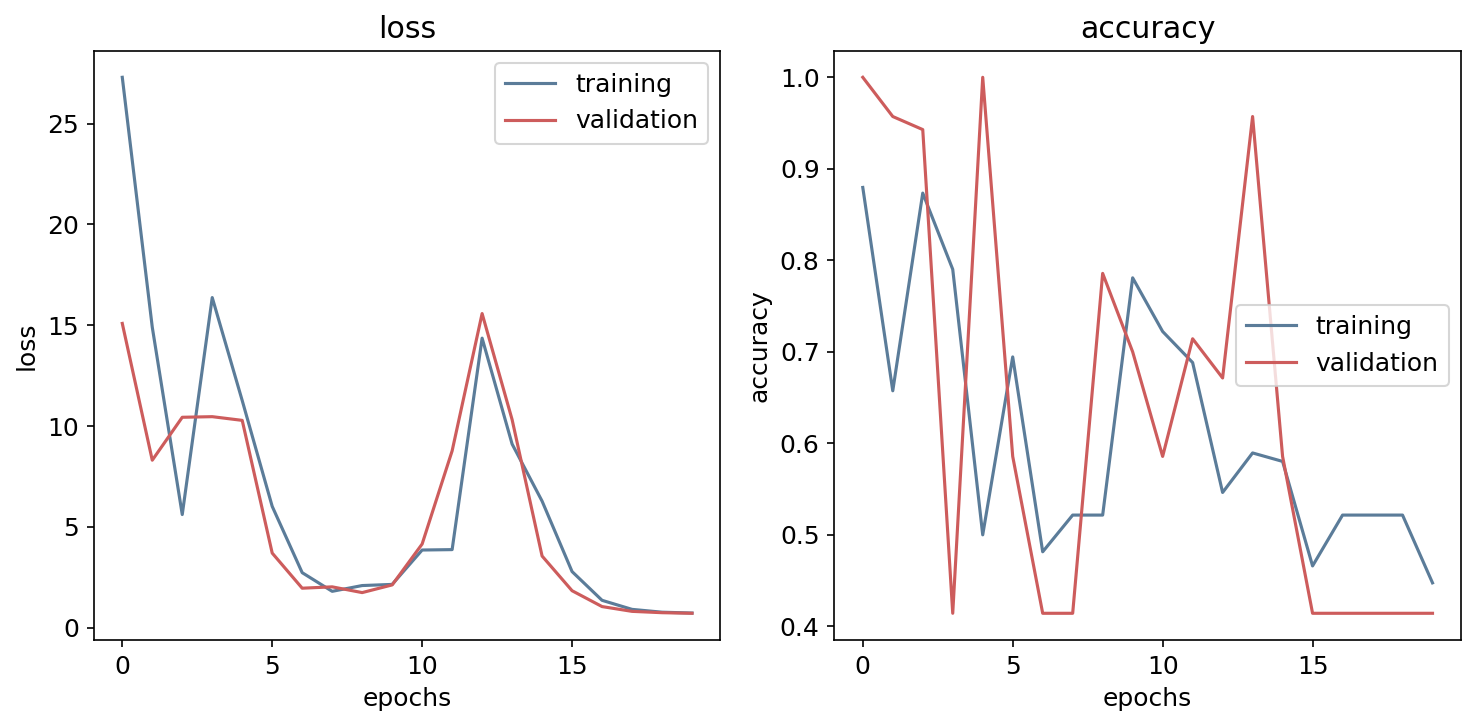

In [28]:
# ---- CREATE the model ----
N_LAYERS = len(HIDDENS)
OUTPUT_NODES = 2

# define the model
model = Sequential()

# define first layer
model.add(Dense(HIDDENS[0],
                activation=ACT_FUNC,
                input_shape=(sst_train.shape[-1],),
                bias_initializer=tf.keras.initializers.RandomNormal(seed=random_seed),
                kernel_initializer=tf.keras.initializers.RandomNormal(seed=random_seed),
                kernel_regularizer=regularizers.L2(l2=RIDGE_PEN)))

# add hidden layers
for LAYER in range(1,N_LAYERS):
    model.add(Dense(HIDDENS[LAYER],
                    activation=ACT_FUNC,
                    bias_initializer=tf.keras.initializers.RandomNormal(seed=random_seed),
                    kernel_initializer=tf.keras.initializers.RandomNormal(seed=random_seed)))

# final layer
model.add(Dense(OUTPUT_NODES,
                activation='softmax',
                bias_initializer=tf.keras.initializers.RandomNormal(seed=random_seed),
                kernel_initializer=tf.keras.initializers.RandomNormal(seed=random_seed),))

# compile
model.compile(optimizer=optimizers.Adam(LR), # you can change the optimizer as well - SGD is another one
              loss=LOSS_FUNC,
              metrics=[metrics.categorical_accuracy] # other metrics to print out while training
              )

# train
history = model.fit(sst_train,nino_train,
                    epochs=N_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(sst_val, nino_val),
                    shuffle=True, verbose=2)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],color='xkcd:slate blue',label='training')
plt.plot(history.history['val_loss'],color='indianred',label='validation')
plt.xlabel("epochs"); plt.ylabel("loss")
plt.title("loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'],color='xkcd:slate blue',label='training')
plt.plot(history.history['val_categorical_accuracy'],color='indianred',label='validation')
plt.xlabel("epochs"); plt.ylabel("accuracy")
plt.title("accuracy")
plt.legend()

plt.tight_layout()

## Model evaluation
How does the model do on unseen data?

In [29]:
nino_pred = model.predict(sst_test) # make predictions for test data

print(nino_pred[:10])

# why do we apply the argmax function?
nino_pred = np.argmax(nino_pred,axis=1)
nino_true = np.argmax(nino_test,axis=1)

modelcorr = nino_pred==nino_true
nmodelcorr = modelcorr[modelcorr].shape[0]
ntest = nino_true.shape[0]
print('Model accuracy on testing is %f%%' %(100*nmodelcorr/ntest))

3/3 [==============================] - 0s 4ms/step
[[0.48945102 0.51054895]
 [0.48945102 0.51054895]
 [0.48945102 0.51054895]
 [0.48945102 0.51054895]
 [0.48945102 0.51054895]
 [0.48945102 0.51054895]
 [0.48945102 0.51054895]
 [0.48945102 0.51054895]
 [0.48945102 0.51054895]
 [0.48945102 0.51054895]]
Model accuracy on testing is 38.571429%


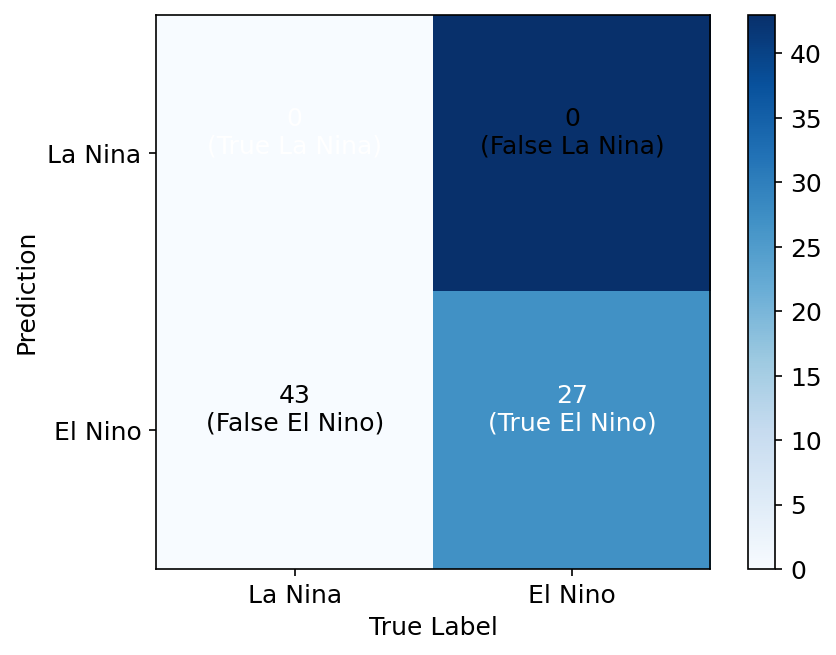

In [30]:
# confusion matrix

cm = tf.math.confusion_matrix(nino_true, nino_pred).numpy()
plt.imshow(cm, cmap = "Blues")
plt.text(x = 0, y = 0, s=str(cm[0,0]) + "\n(True La Nina)", color = "w", ha = "center")
plt.text(x = 0, y = 1, s=str(cm[0,1]) + "\n(False El Nino)", ha = "center")
plt.text(x = 1, y = 0, s=str(cm[1,0]) + "\n(False La Nina)", ha = "center")
plt.text(x = 1, y = 1, s=str(cm[1,1]) + "\n(True El Nino)", color = "w", ha = "center")
plt.xlabel("True Label")
plt.ylabel("Prediction")
plt.colorbar()
plt.xticks((0,1), labels = ["La Nina", "El Nino"])
plt.yticks((0,1), labels = ["La Nina", "El Nino"]);

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


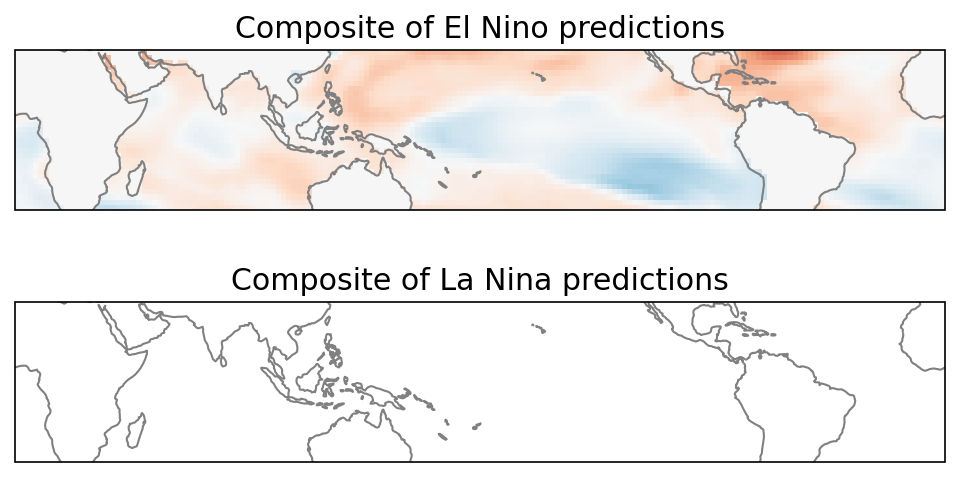

In [31]:
elninopred = (nino_pred==1)
laninapred = (nino_pred==0)

elnino_sst = sst_test[elninopred,:]
elnino_sst = np.reshape(elnino_sst,(elnino_sst.shape[0],sizesst[1],sizesst[2]))
lanina_sst = sst_test[laninapred,:]
lanina_sst = np.reshape(lanina_sst,(lanina_sst.shape[0],sizesst[1],sizesst[2]))

elninoplot = np.mean(elnino_sst,axis=0)
laninaplot = np.mean(lanina_sst,axis=0)

projection = ccrs.PlateCarree(central_longitude=180)
transform = ccrs.PlateCarree()

plt.figure(figsize=(8,4))

ax1=plt.subplot(2,1,1,projection=projection)
ax1.pcolormesh(lon,lat,elninoplot,vmin=-2,vmax=2,cmap='RdBu_r',transform=transform)
ax1.coastlines(color='gray')
plt.title('Composite of El Nino predictions')

ax2=plt.subplot(2,1,2,projection=projection)
ax2.pcolormesh(lon,lat,laninaplot,vmin=-2,vmax=2,cmap='RdBu_r',transform=transform)
ax2.coastlines(color='gray')
plt.title('Composite of La Nina predictions')

plt.show()

## Are you happy with the model? Go ahead and save it.

In [26]:
# if you need to make a folder to save the models to:
!cd drive/MyDrive/OtherPresentations/Lectures/OA2024_CUBoulder # !CHANGE THIS TO YOUR DIRECTORY!
!mkdir -p saved_model
# if the folder already exsists
model.save(path+'saved_model/ENSOmodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
